In [1]:
import yaml
import sys
import os
import numpy as np
import torch 
os.chdir('/home/jonfrey/PLR3')
sys.path.insert(0, os.getcwd())
sys.path.append(os.path.join(os.getcwd() + '/src'))
sys.path.append(os.path.join(os.getcwd() + '/lib'))

import loaders_v2
from loaders_v2 import GenericDataset
from rotations import * 
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
from visu import plot_pcd, Visualizer
import copy
from scipy.spatial.transform import Rotation as R
from helper import re_quat
from PIL import Image, ImageDraw
from deep_im import LossAddS
import copy
#from deep_im import flow_to_trafo
from visu import Visualizer
import matplotlib.pyplot as plt
import k3d
#exp_cfg_path = '/home/jonfrey/PLR3/yaml/exp/exp_ws_deepim_debug_natrix.yml'

env_cfg_path = '/home/jonfrey/PLR3/yaml/env/env_natrix_jonas.yml'
exp_cfg_path = '/home/jonfrey/PLR3/yaml/exp/exp_evaluate_pose_estimation.yml'
h = 480
w = 640
import k3d

def load_from_file(p):
    if os.path.isfile(p):
        with open(p, 'r') as f:
            data = yaml.safe_load(f)
    else:
        raise ValueError
    return data

exp = load_from_file(exp_cfg_path)
env = load_from_file(env_cfg_path)

dataset_train = GenericDataset(
    cfg_d=exp['d_train'],
    cfg_env=env)

batch = dataset_train[13450][0] #bann 10450
points, choose, img, target, model_points, idx = batch[0:6]
depth_img, label_img, img_orig, cam = batch[6:10]
gt_rot_wxyz, gt_trans, unique_desig = batch[10:13]

real_img, render_img, real_d, render_d, gt_label_cropped = batch[13:18]
pred_rot_wxyz, pred_trans, pred_points, h_render,h_real, render_img_original = batch[18:24]
u_map, v_map, flow_mask,  bb = batch[24:]



                

/home/jonfrey/PLR3/src/loaders_v2/dataset_ycb.py:426: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  init_trans = torch.normal(mean=torch.tensor(gt_trans), std=nt)
/home/jonfrey/PLR3/src/helper/bounding_box.py:203: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /opt/conda/conda-bld/pytorch_1595629427478/work/torch/csrc/utils/python_arg_parser.cpp:766.)
  masked_idx = (d != 0).nonzero()
/home/jonfrey/miniconda3/envs/track_latest/lib/python3.7/site-packages/torch/nn/functional.py:3121: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the 

In [2]:
# Plotting Helper Functions (not needed)
class Drawer():
    def __init__(self):
        self.im_in_plot = 0
        self.data = []
        
    def disp_img_1d(self,img,hold=False, save=False, nr=0 , ret=False):
        self.data.append(img)
        p = '/home/jonfrey/Debug/Midterm2/'
        
        if not hold:
            fig = plt.figure(figsize=(6*2*len(self.data),7))
            ax = []
            for j,a in enumerate(self.data):
                ax.append( fig.add_subplot(1,len(self.data), j+1)  )
                
                ax[-1].get_xaxis().set_visible(False)
                ax[-1].get_yaxis().set_visible(False)
                pos = ax[-1].imshow( a, cmap='Reds' )
                
                fig.colorbar(pos, ax=ax[-1])
            plt.show()
            if save:
                fig.savefig(p+str(nr)+'.png', dpi=300)
                
            if ret: 
                if isinstance( self.data[0], torch.Tensor):
                    self.data[0] = self.data[0].numpy()
                    print('CONV')
                    
                print(self.data[0].shape)
                a = np.max(self.data[0])
                b = np.min(self.data[0])
                
                d = (self.data[0]-float(b))
                d = (d / ((float(a)-float(b))) )*255 
                d = np.uint8(d)
                img = Image.fromarray( d )
                return d
            self.data = []
            self.ax = []
            
Nc = 256
cmap = plt.cm.get_cmap('gist_rainbow', Nc)
cmaplist = [cmap(i) for i in range(cmap.N)]

def disp_alignment(depth, label, real):
    data = np.zeros((480,640,4), dtype=np.uint8)
    data_depth = np.zeros((480,640,4), dtype=np.uint8)
    t = real
    data[:,:,:3] = t.numpy() # red patch in upper left
    data_depth[:,:,:3] = t.numpy()
    data[:,:,3] = 70
    data[:,:,3][label==8] = 255
    
    min_val = torch.min( depth[depth!=0] )
    max_val = torch.max( depth[depth!=0] )
    val = torch.clamp( ((depth-min_val) // (max_val-min_val))*255, 0, 255)
    
    img = Image.fromarray(data, 'RGBA')
    display(img)

def plot_mask(mask):
    min_val = torch.min( mask )
    max_val = float( max(1,torch.max( mask )) )
    mask = torch.clamp( (mask-min_val) / (max_val-min_val)*255 ,0,255)
    
    data_depth = np.zeros((480,640,4), dtype=np.uint8)
    data_depth[:,:,3] = 255
    for i in range(480):
        for j in range(640):
            data_depth[i,j,:4] = np.array( cmaplist[ int(mask[i,j])] )*255
    data_depth[:,:,3] = 255
    data_depth[:,:,3][label==2] = 255
    img_depth = Image.fromarray(data_depth, 'RGBA')
    display(img_depth)

def plot_two_pcd_line(x, y, point_size=0.005, c1='g', c2='r'):
    if c1 == 'b':
        k = 245
    elif c1 == 'g':
        k = 25811000
    elif c1 == 'r':
        k = 11801000
    elif c1 == 'black':
        k = 2580
    else:
        k = 2580

    if c2 == 'b':
        k2 = 245
    elif c2 == 'g':
        k2 = 25811000
    elif c2 == 'r':
        k2 = 11801000
    elif c2 == 'black':
        k2 = 2580
    else:
        k2 = 2580

    col1 = np.ones(x.shape[0]) * k
    col2 = np.ones(y.shape[0]) * k2
    plot = k3d.plot(name='points')
    plt_points = k3d.points(x, col1.astype(np.uint32), point_size=point_size)
    plot += plt_points
    plt_points = k3d.points(y, col2.astype(np.uint32), point_size=point_size)
    plot += plt_points
    for i in range(min(100,x.shape[0]) ):
        plot += k3d.line([x[i],y[i]],shader='mesh', width=0.0005, color=0xff0000)
    
    plt_points.shader = '3d'
    plot.display()

def plot_hist(x,n_bins = 20):
    fig, axs = plt.subplots(1, 1, sharey=True, tight_layout=True)
    colors = ['lime']
    axs.hist(x, bins=n_bins, color=colors, label=colors)
    fig.show()
    return fig

In [3]:
# Helper functions 
def get_scale_for_erosion(ero_in):
    res = torch.sum ( ero_in, dim = (2,3))
    res[res < 5000] = 5
    res[res < 10000] = 10
    res[res < 30000] = 20
    res[res < 40000] = 25
    res[res < 50000] = 30
    res[res >= 50000] = 40
    return res

def eroision(t,size=3):
    "t: tensor shape BS, C, H,W"
    out_c = t.shape[1]
    kernel_tensor = torch.ones( (out_c,1,size,size) )
    print(size, kernel_tensor, t.shape)
    return torch.nn.functional.conv2d(t, kernel_tensor, padding=(int((size)/2), int((size)/2))) == (size*size)

def eroision_batch(t,t_size):
    "t: tensor shape BS, C, H,W"
    "t_size: tensor shape BS"
    out_c = t.shape[1]
    for b in range( t.shape[0] ):
        size = int( t_size[b] )
        kernel_tensor = torch.ones( (out_c,1,size,size) )
        t[b] = (torch.nn.functional.conv2d(t[b][None], kernel_tensor, padding=(int((size)/2), int((size)/2))) == (size*size))[0,:,:t.shape[2], :t.shape[3]]
    return t



In [4]:
# How to load a specific datapoint form the dataset (Not Needed)

# [('data/0003/001742',), tensor([8], dtype=torch.int32)]

desig = unique_desig[0]
desig = 'data/0003/001742'

_p_ycb = "/media/scratch1/jonfrey/datasets/YCB_Video_Dataset"
depth = np.array(Image.open(
    '{0}/{1}-depth.png'.format(_p_ycb, desig)))
depth.shape

label = np.array(Image.open(
    '{0}/{1}-label.png'.format(_p_ycb, desig)))
img = np.array(Image.open(
    '{0}/{1}-color.png'.format(_p_ycb, desig)))
batch = dataset_train._backend.getElement( desig, 8)
batch = batch #bann 10450   
model_points = batch[4]
idx = batch[5]  # Be carefull here the first objects starts with 0. Normally 0 is the NO object class in all other datastructures
real_img_original = batch[8]
cam = batch[9]
real_img, render_img, real_d, render_d, gt_label_cropped = batch[13:18]
pred_rot_wxyz, pred_trans, pred_points, h_render, h_real, render_img_original = batch[18:24]
u_map, v_map, flow_mask, bb = batch[24:]


In [5]:
Nc = 256
cmap = plt.cm.get_cmap('gist_rainbow', Nc)
cmaplist = [cmap(i) for i in range(cmap.N)]
import time

In [24]:
# set loader to BS 1
exp['loader']['batch_size'] = 1
exp['loader']['pin_memory'] = False
exp['loader']['shuffle'] = True


exp['d_train']["output_cfg"]['overfitting_nr_idx'] = -1
dataset_train = GenericDataset(
    cfg_d=exp['d_train'],
    cfg_env=env)


# get test and train dataset
dataloader_train = torch.utils.data.DataLoader(dataset_train,
                                                       **exp['loader'])
exp['d_test']["output_cfg"]['overfitting_nr_idx'] = -1
exp['d_test']["flow_cfg"]['sub'] = 1
exp['d_test']["flow_cfg"]['min_matches'] = 50
exp['d_test']["flow_cfg"]['max_matches'] = 3000
exp['d_test']["flow_cfg"]['max_iterations'] = 20000
exp['d_test']["flow_cfg"]['max_iterations'] = 20000


dataset_test = GenericDataset(
    cfg_d=exp['d_test'],
    cfg_env=env)
dataloader_test = torch.utils.data.DataLoader(dataset_test,
                                                       **exp['loader'])

# get Loss function
criterion_adds = LossAddS(sym_list=exp['d_train']['obj_list_sym'])





In [7]:
# Numpy ICP implementation from https://github.com/ClayFlannigan/icp/blob/master/icp.py

import numpy as np
from sklearn.neighbors import NearestNeighbors


def best_fit_transform(A, B):
    '''
    Calculates the least-squares best-fit transform that maps corresponding points A to B in m spatial dimensions
    Input:
      A: Nxm numpy array of corresponding points
      B: Nxm numpy array of corresponding points
    Returns:
      T: (m+1)x(m+1) homogeneous transformation matrix that maps A on to B
      R: mxm rotation matrix
      t: mx1 translation vector
    '''

    assert A.shape == B.shape

    # get number of dimensions
    m = A.shape[1]

    # translate points to their centroids
    centroid_A = np.mean(A, axis=0)
    centroid_B = np.mean(B, axis=0)
    AA = A - centroid_A
    BB = B - centroid_B

    # rotation matrix
    H = np.dot(AA.T, BB)
    U, S, Vt = np.linalg.svd(H)
    R = np.dot(Vt.T, U.T)

    # special reflection case
    if np.linalg.det(R) < 0:
       Vt[m-1,:] *= -1
       R = np.dot(Vt.T, U.T)

    # translation
    t = centroid_B.T - np.dot(R,centroid_A.T)

    # homogeneous transformation
    T = np.identity(m+1)
    T[:m, :m] = R
    T[:m, m] = t

    return T, R, t


def nearest_neighbor(src, dst):
    '''
    Find the nearest (Euclidean) neighbor in dst for each point in src
    Input:
        src: Nxm array of points
        dst: Nxm array of points
    Output:
        distances: Euclidean distances of the nearest neighbor
        indices: dst indices of the nearest neighbor
    '''

    assert src.shape == dst.shape

    neigh = NearestNeighbors(n_neighbors=1)
    neigh.fit(dst)
    distances, indices = neigh.kneighbors(src, return_distance=True)
    return distances.ravel(), indices.ravel()


def icp(A, B, init_pose=None, max_iterations=20, tolerance=0.001):
    '''
    The Iterative Closest Point method: finds best-fit transform that maps points A on to points B
    Input:
        A: Nxm numpy array of source mD points
        B: Nxm numpy array of destination mD point
        init_pose: (m+1)x(m+1) homogeneous transformation
        max_iterations: exit algorithm after max_iterations
        tolerance: convergence criteria
    Output:
        T: final homogeneous transformation that maps A on to B
        distances: Euclidean distances (errors) of the nearest neighbor
        i: number of iterations to converge
    '''

    assert A.shape == B.shape

    # get number of dimensions
    m = A.shape[1]

    # make points homogeneous, copy them to maintain the originals
    src = np.ones((m+1,A.shape[0]))
    dst = np.ones((m+1,B.shape[0]))
    src[:m,:] = np.copy(A.T)
    dst[:m,:] = np.copy(B.T)

    # apply the initial pose estimation
    if init_pose is not None:
        src = np.dot(init_pose, src)

    prev_error = 0

    for i in range(max_iterations):
        # find the nearest neighbors between the current source and destination points
        distances, indices = nearest_neighbor(src[:m,:].T, dst[:m,:].T)

        # compute the transformation between the current source and nearest destination points
        T,_,_ = best_fit_transform(src[:m,:].T, dst[:m,indices].T)

        # update the current source
        src = np.dot(T, src)

        # check error
        mean_error = np.mean(distances)
        if np.abs(prev_error - mean_error) < tolerance:
            break
        prev_error = mean_error

    # calculate final transformation
    T,_,_ = best_fit_transform(A, src[:m,:].T)

    return T, distances, i

In [8]:
idxmax = -1 
def get_H(pcd):
    pcd_ret = torch.ones( (pcd.shape[0],pcd.shape[1]+1),device=pcd.device, dtype=pcd.dtype )
    pcd_ret[:,:3] = pcd
    return pcd_ret

def eval_T(P_real_in_center, P_ren_in_center, T_res):
        """
        NR,3
        NR,3 
        4,4
        """
        P_ren_H = get_H( P_ren_in_center )
        P_ren_trafo =  (P_ren_H @ T_res.T)[:,:3]
        L2_dis_post = torch.mean( torch.norm( P_real_in_center-P_ren_trafo, dim=1 ) )
        L2_dis_pre = torch.mean( torch.norm( P_real_in_center-P_ren_in_center, dim=1 ) )
        return L2_dis_post, L2_dis_pre  

In [27]:
import torch
import numpy as np
import copy
from helper import anal_tensor

def solve_transform(keypoints, gt_keypoints):
    """
    keypoints: N x K x 3
    gt_keypoints: K x 3
    return: N x 4 x 4 transformation matrix
    """
    try:
        keypoints = keypoints.clone()
        gt_keypoints = gt_keypoints.clone()
        N, K, _ = keypoints.shape
        center = keypoints.mean(dim=1)
        gt_center = gt_keypoints.mean(dim=0)
        keypoints -= center[:, None, :]
        gt_keypoints -= gt_center[None]
        matrix = keypoints.transpose(2, 1) @ gt_keypoints[None]
        U, S, V = torch.svd(matrix)
        
        Vt = V.transpose(2, 1)
        Ut = U.transpose(2, 1)

        d = (V @ Ut).det()
        I = torch.eye(3, 3, dtype=gt_center.dtype, device= keypoints.device)[None].repeat(N, 1, 1)
        I[:, 2, 2] = d.clone()

        R = U @ I @ Vt
        T = torch.zeros(N, 4, 4, dtype=gt_center.dtype, device= keypoints.device)
        T[:, 0:3, 0:3] = R
        T[:, 0:3, 3] = center[None] - (R @ gt_center[None :, None])[:, :, 0]
        T[:, 3, 3] = 1.0

        return T
    except RuntimeError as error:
        import ipdb; ipdb.set_trace()
        print("Something went wrong")

# costume implementation 
def solve_transform2(A,B):
    if A.shape[0] > B.shape[0]:
        x=torch.arange(A.shape[0],device=A.device)
        out = torch.randperm(x.numel(),device=A.device)[:B.shape[0]]
        A = torch.index_select(A, 0, out)
    if A.shape[0] < B.shape[0]:
        x=torch.arange(B.shape[0],device=A.device)
        out = torch.randperm(x.numel(),device=A.device)[:A.shape[0]]
        B = torch.index_select(B, 0, out)

    #A = torch.choice(A,B.shape[0])

    assert A.shape == B.shape

    m = A.shape[1]
    centroid_A = torch.mean(A, dim=0)
    centroid_B = torch.mean(B, dim=0)

    AA = (A - centroid_A)
    BB = (B - centroid_B)
    H = AA.transpose(0,1) @ BB
    U, S, Vt = torch.svd(H)
    R = Vt @ U.transpose(0,1)
    if torch.det(R) < 0:
        Vt[m-1,:] *= -1
        R = Vt.transpose(0,1) @ U.transpose(0,1)

    # translation
    t = centroid_B - (R @ centroid_A)
    # homogeneous transformation
    T = torch.eye(m+1, device= A.device)
    T[:m, :m] = R
    T[:m, m] = t
    return T


# NR = 1000
# DIM = 3
# A = torch.ones( (NR,DIM), dtype= torch.float32)
# B = A*1.7223
# T = solve_transform2(A,B)
# print(T)


# A_hom = get_H(A)
# A_hom2 = A_hom @ T.T
# print(A_hom2[:,:3])

def filter_pcd_given_depthmap(pcd, depth, scal= 10000):
    """
    pcd = Nx3 troch.float32
    depth = N torch.float32

    return N torch.bool
    """
    m1 = (depth/scal) > 0.2
    #print( "Thorwn away values", (depth/scal) < 0.2 )
    return m1

    val_d = depth[ m1 ]
    mean = torch.mean(val_d)
    new_d = depth - mean
    tol = 0.5
    m2 = torch.abs( new_d/scal ) < tol 
    return m1 * m2
    
def filter_pcd( pcd, tol = 0.6):
    """
    input:
        pcd : Nx3 torch.float32
    returns:
        mask : NX3 torch.bool 
    """
    m = torch.mean(pcd, dim = 0)
    comp = m[None,:].repeat(pcd.shape[0],1) + tol
    mean_free = pcd-m[None,:].repeat(comp.shape[0],1)
    mask = torch.norm( mean_free,  dim= 1) > tol
    #print(f"filter_pcd PRE: {pcd.shape}, POST: {float(torch.sum(mask[:,None].repeat(1,3) == False ))/3.0}")
    return mask[:,None].repeat(1,3) == False

def filter_pcd_cor(pcd1, pcd2, max_mean_deviation=0.2):
    
    dif = torch.norm( pcd1-pcd2 , dim= 1)
    mean = torch.mean(dif, dim = 0)
    mean_free = torch.abs(dif-mean)
    #print(f"filter_pcd_cor PRE: {pcd1.shape[0]}, POST: {torch.sum(mean_free < max_mean_deviation)}")
    return mean_free < max_mean_deviation
    
def flow_to_trafo(*args, **kwargs):
    """
    input:
      real_br: torch.tensor torch.Size([2])
      real_tl: torch.tensor torch.Size([2])
      ren_br: torch.tensor torch.Size([2])
      ren_tl: torch.tensor torch.Size([2])
      flow_mask: torch.Size([480, 640])
      u_map: torch.Size([480, 640])
      v_map: torch.Size([480, 640])
      K_real: torch.Size([3, 3])
      K_ren: torch.Size([3, 3])
      real_d: torch.Size([480, 640]) 
      render_d: torch.Size([480, 640])
      h_real: torch.Size([4, 4])
      h_render: torch.Size([4, 4])
    output:
      P_real_in_center: torch.Size([N, 3])
      P_ren_in_center: torch.Size([N, 3]) 
      P_real_trafo: torch.Size([N, 3])
      T_res: torch.Size([4, 4])
      
      The output rotation T_res is defined in the Camera coordinate frame. 
      Therfore premultiply the T_Res with h_render to get the new h_real_new !!!
    """
    for k in kwargs.keys():
        pass
        #print(f"Variable: {k}, Type {type(kwargs[k])}, Dtype{kwargs[k].dtype}, Shape{kwargs[k].shape}")
    real_br = kwargs['real_br']
    real_tl = kwargs['real_tl']
    ren_br = kwargs['ren_br']
    ren_tl = kwargs['ren_tl']
    flow_mask = kwargs['flow_mask']
    u_map = kwargs['u_map']
    v_map = kwargs['v_map']
    K_real = kwargs['K_real']
    K_ren = kwargs['K_ren']
    real_d = kwargs['real_d']
    render_d = kwargs['render_d']
    h_real = kwargs['h_real']
    h_render = kwargs['h_render']
    plot_pcd = kwargs.get('plot_pcd',False)
  
    # Grid for upsampled real
    a = float(real_br[0]-real_tl[0])/480*1.0000001
    b = float(real_br[1]-real_tl[1])/640*1.0000001
    grid_real_h = torch.arange(int(real_tl[0]) ,int(real_br[0]) , a, device=u_map.device)[:,None].repeat(1,640)
    grid_real_w = torch.arange(int(real_tl[1]) ,int(real_br[1]) , b, device=u_map.device)[None,:].repeat(480,1)


    # Grid for upsampled ren
    a = float(ren_br[0]-ren_tl[0])/480*1.0000001
    b = float(ren_br[1]-ren_tl[1])/640*1.0000001
    c = 0
    
    grid_ren_h = torch.arange(int(ren_tl[0]) ,int(ren_br[0]) , a, device=u_map.device)[:,None].repeat(1,640)
    grid_ren_w = torch.arange(int(ren_tl[1]) ,int(ren_br[1]) , b, device=u_map.device)[None,:].repeat(480,1)
    # Calculate valid depth map for rendered image
    render_d_ind_h = torch.arange(0 ,480 , 1, device=u_map.device)[:,None].repeat(1,640)
    render_d_ind_w= torch.arange(0 ,640 , 1, device=u_map.device)[None,:].repeat(480,1)

    render_d_ind_h = torch.clamp(torch.round((render_d_ind_h - u_map).type(torch.float32)) ,0,479).type( torch.long )[flow_mask]
    render_d_ind_w = torch.clamp(torch.round((render_d_ind_w - v_map).type(torch.float32)),0,639).type( torch.long )[flow_mask] 
    index = render_d_ind_h*640 + render_d_ind_w # hacky indexing along two dimensions
    ren_d_masked  = render_d.flatten()[index]
    
    # Project depth map to the pointcloud real
    cam_scale = 10000

    real_pixels = torch.stack( [grid_real_w[flow_mask], grid_real_h[flow_mask], torch.ones(grid_real_h.shape, device = u_map.device,  dtype= u_map.dtype)[flow_mask]], dim=1 ).type(u_map.dtype)
    K_inv = torch.inverse(K_real.type(torch.float32)).type(u_map.dtype)
    P_real = K_inv @ real_pixels.T
    P_real = P_real * real_d[flow_mask] / cam_scale
    P_real = P_real.T
    
    # Project depth map to the pointcloud render
    K_ren_inv = torch.inverse(K_ren.type(torch.float32)).type(u_map.dtype)
    ren_pixels = torch.stack( [grid_ren_w[flow_mask] - v_map[flow_mask], 
                            grid_ren_h[flow_mask] - u_map[flow_mask],
                            torch.ones(grid_ren_h.shape, device = u_map.device,  dtype= u_map.dtype )[flow_mask]], 
                            dim=1 ).type(u_map.dtype)
    P_ren = K_ren_inv @ ren_pixels.T
    P_ren = P_ren * ren_d_masked / cam_scale
    P_ren = P_ren.T

    # Filter the pointclouds given the depthmap
    m_ren_depth = filter_pcd_given_depthmap(P_ren, render_d[flow_mask])
    m_real_depth = filter_pcd_given_depthmap(P_real, real_d[flow_mask])
    m_total =  m_ren_depth * m_real_depth
    
    min_points = 20
    if torch.sum(m_total) < min_points:
        print(f'Violation filter pcd_given_depthmap: P_in: {P_ren.shape[0]} P_out: {torch.sum(m_total)}')
        return False, P_real, P_ren, P_real, torch.eye(4, dtype= u_map.dtype, device=u_map.device)

    P_ren = P_ren[m_total] 
    P_real = P_real[m_total]
    # anal_tensor(  P_ren, 'P_ren m_total masked')

    # Do not transfrom to center coordinate system
    P_real_in_center = P_real                      
    P_ren_in_center = P_ren 
    
    m_real = filter_pcd( P_real_in_center )
    m_ren = filter_pcd( P_ren_in_center )
    m_tot = m_real * m_ren
    if torch.sum(m_tot) < min_points:
        print(f'Violation filter_pcd: P_in: { P_ren_in_center.shape[0]} P_out: {torch.sum(m_tot)}')
        return False, P_real, P_ren, P_real, torch.eye(4, dtype= u_map.dtype, device=u_map.device)

    P_real_in_center = P_real_in_center[m_tot[:,0]]
    P_ren_in_center = P_ren_in_center[m_tot[:,0]]
  
    # Max mean deviation
    m_new = filter_pcd_cor(P_real_in_center, P_ren_in_center)
    
    if torch.sum(m_new) < min_points:
        print(f'Violation filter_pcd_cor: P_in: { P_ren_in_center.shape[0]} P_out: {torch.sum(m_new)}')
        return False, P_real, P_ren, P_real, torch.eye(4, dtype= u_map.dtype, device=u_map.device)

    P_real_in_center = P_real_in_center[m_new]
    P_ren_in_center = P_ren_in_center[m_new]

    # random shuffel
    pts_trafo = min( P_real_in_center.shape[0], 1000 )
    idx = torch.randperm( P_real_in_center.shape[0] )[0:pts_trafo]
    P_real_in_center = P_real_in_center[idx]
    P_ren_in_center = P_ren_in_center[idx]

    T_res = solve_transform( P_real_in_center[None].type(torch.float64 ) , P_ren_in_center.type(torch.float64 ) ).type(u_map.dtype )
    
    # Transform the real points according to calculated transformation
    P_hr = torch.ones( (P_real_in_center.shape[0],4 ) , device=u_map.device, dtype= u_map.dtype)
    P_hr[:,:3] = P_real_in_center
    P_real_trafo = (torch.inverse( T_res[0].type(torch.float32) ).type(u_map.dtype ) @ copy.deepcopy(P_hr).T).T [:,:3]

    return True, P_real_in_center, P_ren_in_center, P_real_trafo, T_res[0]
    

In [37]:
from visu import plot_two_pcd
import itertools
# idxmax can be set to != -1 to load specific sample

idxmax = -1 
device = 'cpu'
desig_ls= []
adds_gt_ls = []
adds_init_ls = []
adds_erode_ls = []
adds_n1_ls = []
adds_n2_ls = []
visualizer = Visualizer('/home/jonfrey/Debug', None)
print('START')

K_ren = torch.tensor( dataset_train._backend.get_camera('data_syn/0019', K=True), device=device ) 
max_iter = 1000

if idxmax != -1:
    print(idxmax, "is not equal to -1 load batch")
    batch = next(itertools.islice(dataloader_train, idxmax, None))[0]

for j,ba in enumerate(dataloader_test):
    if j > max_iter-1:
        break
    if j % 10 == 0:
        print(f"Processed {j}/{max_iter}")
    if idxmax == -1:  
        batch = ba[0]
    # use first sample in batch 
    b = 0
    
    model_points = batch[4]
    idx = batch[5]  # Be carefull here the first objects starts with 0. Normally 0 is the NO object class in all other datastructures
    label = batch[7]
    real_img_original = batch[8]
    cam = batch[9]
    gt_rot_wxyz, gt_trans, unique_desig = batch[10:13] # unique_desig[1] contains the idx starting at 1 for the first object 
    bs = model_points.shape[0]
    if batch[13] is False:
        print('Continue')
        continue
    real_img, render_img, real_d, render_d, gt_label_cropped = batch[13:18]
    pred_rot_wxyz, pred_trans, pred_points, h_render, h_real, render_img_original = batch[18:24]
    u_map, v_map, flow_mask, bb = batch[24:]
    real_tl, real_br, ren_tl, ren_br = bb 
    
    data = torch.cat([real_img, render_img], dim=1)
    uv_gt = torch.stack( [u_map, v_map], dim=3 ).permute(0,3,1,2)
    
    
    ero_in = (gt_label_cropped ==  unique_desig[1])[:,None,:,:].type(torch.float32) # BS,C,H,W
    t_size = get_scale_for_erosion(ero_in)
    ero_out = eroision_batch(ero_in,t_size)
    
    # get camera
    K_real = torch.tensor( [[cam[b,2],0,cam[b,0]],[b,cam[b,3],cam[b,1]],[0,0,1]], device=device )
    
    #get inital estimate of the poistion given by the dataloader
    h_real_est = torch.eye(4,device=device)
    h_real_est[:3,:3] = quat_to_rot(pred_rot_wxyz[b][None,:], conv='wxyz', device=device)
    h_real_est[:3,3] = torch.tensor( pred_trans[b].clone().detach() ,device=device )

    
    ### GT Estimate ###
    typ = u_map.dtype
    fmt = flow_mask.dtype
    
     ### GT Label ###
    suc, P_real_in_center, P_ren_in_center, P_real_trafo, gt_T_res = flow_to_trafo(
        real_br = real_br[b].clone(),
        real_tl = (real_tl[b]).clone(), 
        ren_br = (ren_br[b]).clone(), 
        ren_tl = (ren_tl[b]).clone(),
        flow_mask = (flow_mask[b]).clone(), 
        u_map = (u_map[b].type( typ )).clone(),
        v_map = (v_map[b].type( typ )).clone(), 
        K_real = (K_real.type( typ )).clone(),
        K_ren = (K_ren.type( typ )).clone(),
        real_d = (real_d[b].type( typ )).clone(),
        render_d = (render_d[b].type( typ )).clone(),
        h_real = (h_real_est.type( typ )).clone(), 
        h_render = (h_render[b].type( typ )).clone())
    gt_h_est =  gt_T_res @ h_render[0].type(typ)

    if not suc:
        continue
    ### Erode Label ###
    flow_mask_eroded  = (flow_mask * ero_out.type(torch.float32)).type(fmt)[:,0]
    suc,_,_,_, ero_T_res = flow_to_trafo(
        real_br = copy.deepcopy(real_br[b]),
        real_tl = copy.deepcopy(real_tl[b]), 
        ren_br = copy.deepcopy(ren_br[b]), 
        ren_tl = copy.deepcopy(ren_tl[b]),
        flow_mask = copy.deepcopy(flow_mask_eroded[b]), 
        u_map = copy.deepcopy((u_map[b]).type( typ )), 
        v_map = copy.deepcopy((v_map[b]).type( typ )), 
        K_real = copy.deepcopy(K_real.type( typ )),
        K_ren = copy.deepcopy(K_ren.type( typ )),
        real_d = copy.deepcopy(real_d[b].type( typ )),
        render_d = copy.deepcopy(render_d[b].type( typ )),
        h_real = copy.deepcopy(h_real_est.type( typ )), 
        h_render = copy.deepcopy(h_render[b].type( typ )))
    ero_h_est =  ero_T_res @ h_render[0].type(typ) # set rotation
    
    ### N1 ###
    lvl = 20
    n1 = torch.rand(v_map[b].shape, dtype = typ)
    n2 = torch.rand(v_map[b].shape, dtype = typ)
    u_map_clone = (u_map[b]).type( typ ).clone() + (n1 - 0.5) * 2 * lvl
    v_map_clone = (v_map[b]).type( typ ).clone() + (n2 - 0.5) * 2 * lvl
    
    suc,_,_,_, n1_T_res = flow_to_trafo(
        real_br = copy.deepcopy(real_br[b]),
        real_tl = copy.deepcopy(real_tl[b]), 
        ren_br = copy.deepcopy(ren_br[b]), 
        ren_tl = copy.deepcopy(ren_tl[b]),
        flow_mask = copy.deepcopy(flow_mask_eroded[b]), 
        u_map = u_map_clone, 
        v_map = v_map_clone, 
        K_real = copy.deepcopy(K_real.type( typ )),
        K_ren = copy.deepcopy(K_ren.type( typ )),
        real_d = copy.deepcopy(real_d[b].type( typ )),
        render_d = copy.deepcopy(render_d[b].type( typ )),
        h_real = copy.deepcopy(h_real_est.type( typ )), 
        h_render = copy.deepcopy(h_render[b].type( typ )))
    n1_h_est =  n1_T_res @ h_render[0].type(typ) # set rotation
    
    ### N2 ###
    lvl = 20
    n1 = float(torch.rand((1), dtype = typ ))
    n2 = float(torch.rand((1), dtype = typ ))
    u_map_clone = (u_map[b]).type( typ ).clone() + float( (n1 - 0.5) * 2 * lvl )
    v_map_clone = (v_map[b]).type( typ ).clone() + float( (n2 - 0.5) * 2 * lvl )
    
    
    suc,_,_,_, n2_T_res = flow_to_trafo(
        real_br = copy.deepcopy(real_br[b]),
        real_tl = copy.deepcopy(real_tl[b]), 
        ren_br = copy.deepcopy(ren_br[b]), 
        ren_tl = copy.deepcopy(ren_tl[b]),
        flow_mask = copy.deepcopy(flow_mask_eroded[b]), 
        u_map = u_map_clone, 
        v_map = v_map_clone, 
        K_real = copy.deepcopy(K_real.type( typ )),
        K_ren = copy.deepcopy(K_ren.type( typ )),
        real_d = copy.deepcopy(real_d[b].type( typ )),
        render_d = copy.deepcopy(render_d[b].type( typ )),
        h_real = copy.deepcopy(h_real_est.type( typ )), 
        h_render = copy.deepcopy(h_render[b].type( typ )))
    n2_h_est =  n2_T_res @ h_render[0].type(typ) # set rotation
    
    
    if not suc:
        continue
    mask = (flow_mask == True)

    # Target Model-points Transformed
    p = model_points.shape[1]
    target = torch.bmm( model_points, torch.transpose(h_real[:,:3,:3], 1,2 ) ) + h_real[:,:3,3][:,None,:].repeat(1,p,1)

    # Compute ADD-S
    adds_res_gt_flow = criterion_adds(target[b][None].clone(), model_points[b][None].clone(), idx[b][None], H = gt_h_est[None].type( target.dtype) )
    adds_res_gt_flow_eroded = criterion_adds(target[b][None], model_points[b][None], idx[b][None], H = ero_h_est[None].type( target.dtype) )
    adds_res_n1 = criterion_adds(target[b][None].clone(), model_points[b][None].clone(), idx[b][None], H = n1_h_est[None].type( target.dtype) )
    adds_res_n2 = criterion_adds(target[b][None], model_points[b][None], idx[b][None], H = n2_h_est[None].type( target.dtype) )
    
    
    adds_init = criterion_adds(target[b][None].clone(), model_points[b][None].clone(), idx[b][None], H = h_real_est[None].type( target.dtype))
    
    # Append results to list
    desig_ls.append(int( unique_desig[1]) )
    adds_init_ls.append(float(adds_init.detach()))
    adds_gt_ls.append(float(adds_res_gt_flow.detach()))
    adds_erode_ls.append(float(adds_res_gt_flow_eroded.detach()))    
    adds_n1_ls.append(float(adds_res_n1.detach()))
    adds_n2_ls.append(float(adds_res_n2.detach()))

    if adds_gt_ls[-1] > 0.02 :
        print(f'Failed Iteration {j} > 0.02 ADD-S, GT', adds_gt_ls[-1] , 'ERRODED', adds_erode_ls[-1]  )
        
        no = torch.norm(P_real_trafo- P_ren_in_center, dim=1)
        print( f'    shape of use points: ',P_real_trafo.shape )
        print( f'    number of point with a distance greater 0.2 {torch.sum( no>0.2 )} ' )
        print( f'    number of point with a distance greater 0.02 {torch.sum( no>0.02 )} ' )
        print( f'    number of point with a distance smaller 0.02 {torch.sum( no<0.02 )} ' )
        
        
        plot1 = True
    else:
        print(f'Suc Iteration {j} < 0.02 ADD-S, GT', adds_gt_ls[-1] , 'ERRODED', adds_erode_ls[-1]  )
        plot1 = False
    if idxmax != -1:
        plot1 = True
        
    

    if plot1:
        continue
#         print("Real depth map cropped")
#         real_depth_img = Drawer().disp_img_1d(real_d[b].numpy(),ret=True)
#         real_depth_img = np.repeat( real_depth_img[:,:,None],3, axis=2)
#         print("Render depth map cropped")
#         render_depth_img = Drawer().disp_img_1d(render_d[b].numpy(),ret=True)
#         render_depth_img = np.repeat( render_depth_img[:,:,None],3, axis=2)
#         Drawer().disp_img_1d(flow_mask[0],ret=True)

#         sub = max(1,int( P_real_in_center.shape[0]/100 ) )
#         plot_two_pcd_line(P_real_in_center[::sub].numpy(), P_ren_in_center[::sub].numpy() )
#         plot_two_pcd_line(P_real_trafo[::sub].numpy(), P_ren_in_center[::sub].numpy() )

#         print(f"Real Image, Estimated Points given GT Flow {P_real_in_center.shape}")
#         visualizer.plot_estimated_pose( tag = f"_",
#                         epoch = 1,
#                         img= real_img_original[b].cpu().numpy(),
#                         points = copy.deepcopy( P_real_in_center.cpu().numpy()),
#                         store = False,
#                         jupyter=True,
#                         K = K_real.cpu().numpy(),
#                         H = np.eye(4),
#                         method='def')
#         print("Real Image Cropped, Estimated Points given GT Flow")
#         visualizer.plot_estimated_pose_on_bb( tag = f"_",
#                         epoch = 1,
#                         img= real_depth_img,
#                         tl = real_tl[0],
#                         br = real_br[0],
#                         points = copy.deepcopy( P_real_in_center.cpu().numpy()),
#                         store = False,
#                         jupyter=True,
#                         K = K_real.cpu().numpy(),
#                         H = np.eye(4),
#                         method='def')

#         fil = label == unique_desig[1]    
#         real_img_original[b][ fil[0][:,:,None].repeat(1,1,3) ] = 255
#         print("Real Image, Estimated Points given GT Flow with label is white")
#         visualizer.plot_estimated_pose( tag = f"_",
#                         epoch = 1,
#                         img= real_img_original[b].cpu().numpy(),
#                         points = copy.deepcopy( P_real_in_center.cpu().numpy()),
#                         store = False,
#                         jupyter=True,
#                         K = K_real.cpu().numpy(),
#                         H = np.eye(4),
#                         method='def')

#         print("Render Image, Rendered Points not transformed reprojected")
#         visualizer.plot_estimated_pose( tag = f"_",
#                             epoch = 1,
#                             img= render_img_original[b].cpu().numpy(),
#                             points = copy.deepcopy(P_ren_in_center.cpu().numpy()),
#                             store = False,
#                             jupyter=True,
#                             K = K_ren.cpu().numpy(),
#                             H = np.eye(4),
#                             method='def')
#         print("Render Image Cropped, Rendered Points not transformed reprojected")
#         visualizer.plot_estimated_pose_on_bb( tag = f"_",
#                             epoch = 1,
#                             img= render_depth_img,
#                             points = copy.deepcopy(P_ren_in_center.cpu().numpy()),
#                             tl = ren_tl[0],
#                             br = ren_br[0],
#                             store = False,
#                             jupyter=True,
#                             K = K_ren.cpu().numpy(),
#                             H = np.eye(4),
#                             method='def')

        print('Valid Flow Mask')
        visualizer.plot_segmentation('tag', 1, flow_mask_eroded[b] , store=False, method='def', jupyter=True)
        visualizer.plot_segmentation('tag', 1, flow_mask[b]  , store=False, method='def', jupyter=True)

        print("Corrospondence")
        visualizer.plot_corrospondence(tag=f'_',
                                           epoch=0,
                                            u_map=u_map[0], 
                                            v_map=v_map[0], 
                                            flow_mask=flow_mask[0], 
                                            real_img=real_img[0], 
                                            render_img=render_img[0],
                                            store=False,
                                            jupyter=True,
                                            coloful=True,
                                            method='def',
                                            res_h=1,
                                            res_w=1)

        
# print(f'Result, GT Avg', sum(adds_gt_ls)/len(adds_gt_ls), 'Errode Avg', sum(adds_erode_ls)/len(adds_erode_ls) )


START


/home/jonfrey/PLR3/src/loaders_v2/dataset_ycb.py:426: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  init_trans = torch.normal(mean=torch.tensor(gt_trans), std=nt)
/home/jonfrey/miniconda3/envs/track_latest/lib/python3.7/site-packages/torch/nn/functional.py:3121: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))
/home/jonfrey/PLR3/src/loaders_v2/dataset_ycb.py:426: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  init_trans = torch.normal(mean=torch.tenso

Processed 0/1000


/home/jonfrey/miniconda3/envs/track_latest/lib/python3.7/site-packages/ipykernel_launcher.py:62: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Suc Iteration 0 < 0.02 ADD-S, GT 0.005749182775616646 ERRODED 0.005849858280271292
Failed Iteration 1 > 0.02 ADD-S, GT 0.021748404949903488 ERRODED 0.021746478974819183
    shape of use points:  torch.Size([1000, 3])
    number of point with a distance greater 0.2 0 
    number of point with a distance greater 0.02 1 
    number of point with a distance smaller 0.02 999 
Suc Iteration 2 < 0.02 ADD-S, GT 0.007102621253579855 ERRODED 0.007527205627411604
Suc Iteration 3 < 0.02 ADD-S, GT 0.009310991503298283 ERRODED 0.0103281419724226
Suc Iteration 4 < 0.02 ADD-S, GT 0.0073777553625404835 ERRODED 0.007064813748002052
Suc Iteration 5 < 0.02 ADD-S, GT 0.0028451678808778524 ERRODED 0.0030542630702257156
Suc Iteration 6 < 0.02 ADD-S, GT 0.008241502568125725 ERRODED 0.007912085391581059
Suc Iteration 7 < 0.02 ADD-S, GT 0.0017130014020949602 ERRODED 0.0025933871511369944
Suc Iteration 8 < 0.02 ADD-S, GT 0.004990653600543737 ERRODED 0.004258365370333195
Suc Iteration 9 < 0.02 ADD-S, GT 0.0086692

Suc Iteration 77 < 0.02 ADD-S, GT 0.015004848130047321 ERRODED 0.014330415986478329
Suc Iteration 78 < 0.02 ADD-S, GT 0.010212856344878674 ERRODED 0.010034640319645405
Suc Iteration 79 < 0.02 ADD-S, GT 0.007551665883511305 ERRODED 0.0066838981583714485
Processed 80/1000
Suc Iteration 80 < 0.02 ADD-S, GT 0.008189116604626179 ERRODED 0.004810960963368416
Failed Iteration 81 > 0.02 ADD-S, GT 0.02082981914281845 ERRODED 0.026689622551202774
    shape of use points:  torch.Size([1000, 3])
    number of point with a distance greater 0.2 0 
    number of point with a distance greater 0.02 0 
    number of point with a distance smaller 0.02 1000 
Failed Iteration 82 > 0.02 ADD-S, GT 0.033579498529434204 ERRODED 0.03001422807574272
    shape of use points:  torch.Size([1000, 3])
    number of point with a distance greater 0.2 0 
    number of point with a distance greater 0.02 100 
    number of point with a distance smaller 0.02 900 
Suc Iteration 83 < 0.02 ADD-S, GT 0.005269496235996485 ERROD

Processed 140/1000
Suc Iteration 140 < 0.02 ADD-S, GT 0.0030632668640464544 ERRODED 0.003006866667419672
Suc Iteration 141 < 0.02 ADD-S, GT 0.012842901982367039 ERRODED 0.012620081193745136
Suc Iteration 142 < 0.02 ADD-S, GT 0.007154740858823061 ERRODED 0.007499574683606625
Suc Iteration 143 < 0.02 ADD-S, GT 0.010679096914827824 ERRODED 0.009207921102643013
Suc Iteration 144 < 0.02 ADD-S, GT 0.012736048549413681 ERRODED 0.010735774412751198
Suc Iteration 145 < 0.02 ADD-S, GT 0.0035994742065668106 ERRODED 0.003057723166421056
Failed Iteration 146 > 0.02 ADD-S, GT 0.040174469351768494 ERRODED 0.03994269296526909
    shape of use points:  torch.Size([1000, 3])
    number of point with a distance greater 0.2 0 
    number of point with a distance greater 0.02 0 
    number of point with a distance smaller 0.02 1000 
Suc Iteration 147 < 0.02 ADD-S, GT 0.006710073444992304 ERRODED 0.003461970714852214
Suc Iteration 148 < 0.02 ADD-S, GT 0.004504349548369646 ERRODED 0.004590211436152458
Failed

Suc Iteration 202 < 0.02 ADD-S, GT 0.015404550358653069 ERRODED 0.015483247116208076
Suc Iteration 203 < 0.02 ADD-S, GT 0.00463322876021266 ERRODED 0.005569212604314089
Suc Iteration 204 < 0.02 ADD-S, GT 0.0049226535484194756 ERRODED 0.005129301454871893
Failed Iteration 205 > 0.02 ADD-S, GT 0.022152559831738472 ERRODED 0.02540314756333828
    shape of use points:  torch.Size([1000, 3])
    number of point with a distance greater 0.2 0 
    number of point with a distance greater 0.02 111 
    number of point with a distance smaller 0.02 889 
Suc Iteration 206 < 0.02 ADD-S, GT 0.011637701652944088 ERRODED 0.011545834131538868
Suc Iteration 207 < 0.02 ADD-S, GT 0.01588604412972927 ERRODED 0.016726823523640633
Suc Iteration 208 < 0.02 ADD-S, GT 0.002596608828753233 ERRODED 0.0031994220335036516
Suc Iteration 209 < 0.02 ADD-S, GT 0.012931372970342636 ERRODED 0.013390878215432167
Processed 210/1000
Suc Iteration 210 < 0.02 ADD-S, GT 0.0051923175342381 ERRODED 0.006266591139137745
Suc Itera

Suc Iteration 268 < 0.02 ADD-S, GT 0.0043949163518846035 ERRODED 0.004932065960019827
Suc Iteration 269 < 0.02 ADD-S, GT 0.010149563662707806 ERRODED 0.008382398635149002
Processed 270/1000
Suc Iteration 270 < 0.02 ADD-S, GT 0.0057393149472773075 ERRODED 0.005446400493383408
Suc Iteration 271 < 0.02 ADD-S, GT 0.008066310547292233 ERRODED 0.007077631074935198
Suc Iteration 272 < 0.02 ADD-S, GT 0.005022875498980284 ERRODED 0.005181287880986929
Suc Iteration 273 < 0.02 ADD-S, GT 0.00394836813211441 ERRODED 0.003657196182757616
Failed Iteration 274 > 0.02 ADD-S, GT 0.030903950333595276 ERRODED 0.029141291975975037
    shape of use points:  torch.Size([1000, 3])
    number of point with a distance greater 0.2 0 
    number of point with a distance greater 0.02 78 
    number of point with a distance smaller 0.02 922 
Suc Iteration 275 < 0.02 ADD-S, GT 0.005928555503487587 ERRODED 0.00415452616289258
Suc Iteration 276 < 0.02 ADD-S, GT 0.009782709181308746 ERRODED 0.003841196885332465
Suc Ite

Suc Iteration 338 < 0.02 ADD-S, GT 0.005440438166260719 ERRODED 0.005594039335846901
Suc Iteration 339 < 0.02 ADD-S, GT 0.01385524496436119 ERRODED 0.013852115720510483
Processed 340/1000
Suc Iteration 340 < 0.02 ADD-S, GT 0.010026202537119389 ERRODED 0.00855779554694891
Suc Iteration 341 < 0.02 ADD-S, GT 0.019673312082886696 ERRODED 0.019796980544924736
Failed Iteration 342 > 0.02 ADD-S, GT 0.03138309344649315 ERRODED 0.031032346189022064
    shape of use points:  torch.Size([1000, 3])
    number of point with a distance greater 0.2 0 
    number of point with a distance greater 0.02 0 
    number of point with a distance smaller 0.02 1000 
Suc Iteration 343 < 0.02 ADD-S, GT 0.011965956538915634 ERRODED 0.01077305804938078
Suc Iteration 344 < 0.02 ADD-S, GT 0.002186536556109786 ERRODED 0.002407308202236891
Suc Iteration 345 < 0.02 ADD-S, GT 0.0011154834646731615 ERRODED 0.0013103546807542443
Violation filter pcd_given_depthmap: P_in: 31449 P_out: 0
Suc Iteration 347 < 0.02 ADD-S, GT 0

Suc Iteration 418 < 0.02 ADD-S, GT 0.008466371335089207 ERRODED 0.007716083433479071
Suc Iteration 419 < 0.02 ADD-S, GT 0.014153198339045048 ERRODED 0.014387721195816994
Processed 420/1000
Suc Iteration 420 < 0.02 ADD-S, GT 0.006152150221168995 ERRODED 0.006485233083367348
Suc Iteration 421 < 0.02 ADD-S, GT 0.003334206994622946 ERRODED 0.0031022087205201387
Suc Iteration 422 < 0.02 ADD-S, GT 0.007570259273052216 ERRODED 0.008342176675796509
Suc Iteration 423 < 0.02 ADD-S, GT 0.004225568380206823 ERRODED 0.0035709436051547527
Suc Iteration 424 < 0.02 ADD-S, GT 0.005058581940829754 ERRODED 0.006426881067454815
Suc Iteration 425 < 0.02 ADD-S, GT 0.0099841533228755 ERRODED 0.010398412123322487
Suc Iteration 426 < 0.02 ADD-S, GT 0.00455923518165946 ERRODED 0.0057968138717114925
Suc Iteration 427 < 0.02 ADD-S, GT 0.012887394987046719 ERRODED 0.00982733629643917
Suc Iteration 428 < 0.02 ADD-S, GT 0.0010799355804920197 ERRODED 0.0019067886751145124
Suc Iteration 429 < 0.02 ADD-S, GT 0.01462617

Suc Iteration 489 < 0.02 ADD-S, GT 0.010447070933878422 ERRODED 0.009379452094435692
Processed 490/1000
Suc Iteration 490 < 0.02 ADD-S, GT 0.002600414212793112 ERRODED 0.002187538892030716
Suc Iteration 491 < 0.02 ADD-S, GT 0.00992704275995493 ERRODED 0.006674918811768293
Suc Iteration 492 < 0.02 ADD-S, GT 0.008497225120663643 ERRODED 0.0072750309482216835
Failed Iteration 493 > 0.02 ADD-S, GT 0.03083830513060093 ERRODED 0.030952611938118935
    shape of use points:  torch.Size([1000, 3])
    number of point with a distance greater 0.2 0 
    number of point with a distance greater 0.02 11 
    number of point with a distance smaller 0.02 989 
Suc Iteration 494 < 0.02 ADD-S, GT 0.013690807856619358 ERRODED 0.01172194629907608
Suc Iteration 495 < 0.02 ADD-S, GT 0.004656082484871149 ERRODED 0.005460786633193493
Suc Iteration 496 < 0.02 ADD-S, GT 0.007484871428459883 ERRODED 0.007771228905767202
Suc Iteration 497 < 0.02 ADD-S, GT 0.00975112710148096 ERRODED 0.00851880107074976
Suc Iterati

Suc Iteration 560 < 0.02 ADD-S, GT 0.005196679383516312 ERRODED 0.0031656587962061167
Suc Iteration 561 < 0.02 ADD-S, GT 0.004384022206068039 ERRODED 0.005150845739990473
Suc Iteration 562 < 0.02 ADD-S, GT 0.008302786387503147 ERRODED 0.007288326509296894
Suc Iteration 563 < 0.02 ADD-S, GT 0.007105634082108736 ERRODED 0.008620786480605602
Suc Iteration 564 < 0.02 ADD-S, GT 0.00908336229622364 ERRODED 0.0033115919213742018
Suc Iteration 565 < 0.02 ADD-S, GT 0.0059724235907197 ERRODED 0.005998453591018915
Suc Iteration 566 < 0.02 ADD-S, GT 0.005609095096588135 ERRODED 0.006642333697527647
Suc Iteration 567 < 0.02 ADD-S, GT 0.019094886258244514 ERRODED 0.019443852826952934
Suc Iteration 568 < 0.02 ADD-S, GT 0.0026832218281924725 ERRODED 0.0028666844591498375
Suc Iteration 569 < 0.02 ADD-S, GT 0.004115198738873005 ERRODED 0.004293664824217558
Processed 570/1000
Suc Iteration 570 < 0.02 ADD-S, GT 0.0033072438091039658 ERRODED 0.003112338948994875
Suc Iteration 571 < 0.02 ADD-S, GT 0.0058294

Processed 630/1000
Suc Iteration 630 < 0.02 ADD-S, GT 0.003076887223869562 ERRODED 0.002783346688374877
Suc Iteration 631 < 0.02 ADD-S, GT 0.010486852377653122 ERRODED 0.010405275970697403
Suc Iteration 632 < 0.02 ADD-S, GT 0.011161291040480137 ERRODED 0.010044329799711704
Failed Iteration 633 > 0.02 ADD-S, GT 0.029331110417842865 ERRODED 0.025426629930734634
    shape of use points:  torch.Size([1000, 3])
    number of point with a distance greater 0.2 0 
    number of point with a distance greater 0.02 259 
    number of point with a distance smaller 0.02 741 
Suc Iteration 634 < 0.02 ADD-S, GT 0.006331640295684338 ERRODED 0.006413683295249939
Failed Iteration 635 > 0.02 ADD-S, GT 0.05056041479110718 ERRODED 0.017384249716997147
    shape of use points:  torch.Size([1000, 3])
    number of point with a distance greater 0.2 0 
    number of point with a distance greater 0.02 112 
    number of point with a distance smaller 0.02 888 
Suc Iteration 636 < 0.02 ADD-S, GT 0.006876594386994

Suc Iteration 704 < 0.02 ADD-S, GT 0.015267363749444485 ERRODED 0.016899041831493378
Failed Iteration 705 > 0.02 ADD-S, GT 0.05804162099957466 ERRODED 0.0584314689040184
    shape of use points:  torch.Size([1000, 3])
    number of point with a distance greater 0.2 0 
    number of point with a distance greater 0.02 2 
    number of point with a distance smaller 0.02 998 
Suc Iteration 706 < 0.02 ADD-S, GT 0.006503693759441376 ERRODED 0.0013354410184547305
Suc Iteration 707 < 0.02 ADD-S, GT 0.002211658749729395 ERRODED 0.0030769207514822483
Suc Iteration 708 < 0.02 ADD-S, GT 0.014078469946980476 ERRODED 0.008436545729637146
Suc Iteration 709 < 0.02 ADD-S, GT 0.00381019851192832 ERRODED 0.0041412184946238995
Processed 710/1000
Violation filter pcd_given_depthmap: P_in: 36755 P_out: 0
Failed Iteration 711 > 0.02 ADD-S, GT 0.02123551443219185 ERRODED 0.02154543437063694
    shape of use points:  torch.Size([1000, 3])
    number of point with a distance greater 0.2 0 
    number of point w

Processed 780/1000
Suc Iteration 780 < 0.02 ADD-S, GT 0.00252861762419343 ERRODED 0.0029682947788387537
Suc Iteration 781 < 0.02 ADD-S, GT 0.002061465522274375 ERRODED 0.0018360282992944121
Suc Iteration 782 < 0.02 ADD-S, GT 0.003586339997127652 ERRODED 0.003632045816630125
Suc Iteration 783 < 0.02 ADD-S, GT 0.016738763079047203 ERRODED 0.0161800067871809
Suc Iteration 784 < 0.02 ADD-S, GT 0.00859193317592144 ERRODED 0.008486410602927208
Failed Iteration 785 > 0.02 ADD-S, GT 0.03589509800076485 ERRODED 0.036162108182907104
    shape of use points:  torch.Size([1000, 3])
    number of point with a distance greater 0.2 0 
    number of point with a distance greater 0.02 39 
    number of point with a distance smaller 0.02 961 
Suc Iteration 786 < 0.02 ADD-S, GT 0.004113792907446623 ERRODED 0.0028826300986111164
Suc Iteration 787 < 0.02 ADD-S, GT 0.005589800421148539 ERRODED 0.006162539124488831
Suc Iteration 788 < 0.02 ADD-S, GT 0.0028005046769976616 ERRODED 0.0024229937698692083
Failed 

Suc Iteration 841 < 0.02 ADD-S, GT 0.005127312149852514 ERRODED 0.0049148197285830975
Suc Iteration 842 < 0.02 ADD-S, GT 0.00110935780685395 ERRODED 0.0026396599132567644
Suc Iteration 843 < 0.02 ADD-S, GT 0.0028770482167601585 ERRODED 0.0029354398138821125
Suc Iteration 844 < 0.02 ADD-S, GT 0.0037938959430903196 ERRODED 0.0011958307586610317
Violation filter pcd_given_depthmap: P_in: 42697 P_out: 0
Failed Iteration 846 > 0.02 ADD-S, GT 0.021137280389666557 ERRODED 0.021512236446142197
    shape of use points:  torch.Size([1000, 3])
    number of point with a distance greater 0.2 0 
    number of point with a distance greater 0.02 5 
    number of point with a distance smaller 0.02 995 
Suc Iteration 847 < 0.02 ADD-S, GT 0.007506843190640211 ERRODED 0.005563037935644388
Violation filter_pcd_cor: P_in: 21 P_out: 12
Failed Iteration 848 > 0.02 ADD-S, GT 0.025313908234238625 ERRODED 0.029919026419520378
    shape of use points:  torch.Size([1000, 3])
    number of point with a distance gr

Suc Iteration 910 < 0.02 ADD-S, GT 0.015820225700736046 ERRODED 0.015441365540027618
Suc Iteration 911 < 0.02 ADD-S, GT 0.0028148270212113857 ERRODED 0.002694402588531375
Failed Iteration 912 > 0.02 ADD-S, GT 0.023545242846012115 ERRODED 0.023117555305361748
    shape of use points:  torch.Size([1000, 3])
    number of point with a distance greater 0.2 0 
    number of point with a distance greater 0.02 8 
    number of point with a distance smaller 0.02 992 
Suc Iteration 913 < 0.02 ADD-S, GT 0.006476991809904575 ERRODED 0.003739922074601054
Suc Iteration 914 < 0.02 ADD-S, GT 0.0020951912738382816 ERRODED 0.0020616764668375254
Failed Iteration 915 > 0.02 ADD-S, GT 0.042098529636859894 ERRODED 0.03592763468623161
    shape of use points:  torch.Size([1000, 3])
    number of point with a distance greater 0.2 0 
    number of point with a distance greater 0.02 21 
    number of point with a distance smaller 0.02 979 
Suc Iteration 916 < 0.02 ADD-S, GT 0.002430847380310297 ERRODED 0.00238

Suc Iteration 979 < 0.02 ADD-S, GT 0.00825463142246008 ERRODED 0.007363639306277037
Processed 980/1000
Suc Iteration 980 < 0.02 ADD-S, GT 0.006685798522084951 ERRODED 0.006408072542399168
Suc Iteration 981 < 0.02 ADD-S, GT 0.01208820752799511 ERRODED 0.008245429955422878
Suc Iteration 982 < 0.02 ADD-S, GT 0.010972293093800545 ERRODED 0.011295923963189125
Suc Iteration 983 < 0.02 ADD-S, GT 0.005169956479221582 ERRODED 0.005104855168610811
Suc Iteration 984 < 0.02 ADD-S, GT 0.002539493842050433 ERRODED 0.0015905428444966674
Failed Iteration 985 > 0.02 ADD-S, GT 0.03440464287996292 ERRODED 0.03475913777947426
    shape of use points:  torch.Size([1000, 3])
    number of point with a distance greater 0.2 0 
    number of point with a distance greater 0.02 2 
    number of point with a distance smaller 0.02 998 
Suc Iteration 986 < 0.02 ADD-S, GT 0.004710962530225515 ERRODED 0.004397554788738489
Failed Iteration 987 > 0.02 ADD-S, GT 0.09099848568439484 ERRODED 0.09068068861961365
    shape 

In [38]:
import pandas
data = np.array( [desig_ls,adds_gt_ls,adds_init_ls,adds_erode_ls, adds_n1_ls, adds_n2_ls] ).T
df = pandas.DataFrame( data, columns = ['ID','ADD-S GT','ADD-S INITAL','ADD-S Eroded Mask', 'ADD-S Random', 'ADD-S Bias'] )
df

,ID,ADD-S GT,ADD-S INITAL,ADD-S Eroded Mask,ADD-S Random,ADD-S Bias
0,6.0,0.005749,0.026572,0.005850,0.005966,0.004943
1,3.0,0.021748,0.049691,0.021746,0.021469,0.020703
2,19.0,0.007103,0.024054,0.007527,0.007099,0.007450
3,4.0,0.009311,0.024112,0.010328,0.009514,0.014413
4,12.0,0.007378,0.019881,0.007065,0.005179,0.021257
...,...,...,...,...,...,...
976,5.0,0.002457,0.031174,0.002551,0.003029,0.007276
977,19.0,0.028239,0.038061,0.026597,0.026388,0.029105
978,10.0,0.032009,0.047881,0.034172,0.035712,0.035735
979,19.0,0.002269,0.021535,0.002232,0.002441,0.004634


In [41]:
print('Random: Takeing Ground Truth Flow and adding noise uniform in between +20 -20 pixels for each pixel')
print('Bias: Takeing Ground Truth Flow and offsetting the flow by a random value in between +20 -20 pixels for the full image')
df.groupby(['ID']).mean()

Random: Takeing Ground Truth Flow and adding noise uniform in between +20 -20 pixels for each pixel
Bias: Takeing Ground Truth Flow and offsetting the flow by a random value in between +20 -20 pixels for the full image


,ADD-S GT,ADD-S INITAL,ADD-S Eroded Mask,ADD-S Random,ADD-S Bias
ID,,,,,
1.0,0.005779,0.035577,0.005346,0.005254,0.008599
2.0,0.009214,0.045749,0.005693,0.005640,0.021031
3.0,0.010345,0.038753,0.010298,0.010955,0.014873
4.0,0.011588,0.035006,0.011539,0.014134,0.024551
5.0,0.002647,0.035947,0.002633,0.003123,0.009351
6.0,0.029798,0.034513,0.029558,0.029387,0.030955
7.0,0.009208,0.034368,0.009427,0.009180,0.010797
8.0,0.014375,0.032448,0.014423,0.014353,0.015800
9.0,0.013343,0.033701,0.013331,0.013095,0.020804


In [23]:
print("MEAN:\n", df.mean() )
print("\n \nSTD:\n", df.std() )
print("\n \nMAX:\n", df.max())
print("\n \nIDXMAX:\n", df.idxmax())

idxmax = df.idxmax()[0]
print(f'\n \nWorst Sample Index is {idxmax}')

MEAN:
 ID                   12.000000
ADD-S GT              0.014827
ADD-S INITAL          0.031711
ADD-S Eroded Mask     0.017268
dtype: float64

 
STD:
 ID                   7.439996
ADD-S GT             0.017969
ADD-S INITAL         0.015322
ADD-S Eroded Mask    0.023922
dtype: float64

 
MAX:
 ID                   20.000000
ADD-S GT              0.117697
ADD-S INITAL          0.081722
ADD-S Eroded Mask     0.141534
dtype: float64

 
IDXMAX:
 ID                    4
ADD-S GT             84
ADD-S INITAL         89
ADD-S Eroded Mask    89
dtype: int64

 
Worst Sample Index is 4


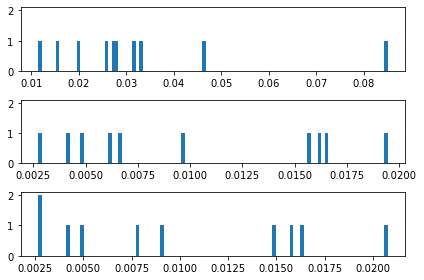

In [13]:
ls = adds_erode_ls
n_bins = 100
failures_filter = 0.1
fig, axs = plt.subplots(3, 1, sharey=True, tight_layout=True)
axs[0].hist(adds_init_ls, bins=n_bins)

adds_gt_f = [a for a in adds_gt_ls if a < failures_filter]
adds_erode_f = [a for a in adds_erode_ls if a < failures_filter]

axs[1].hist(adds_gt_f, bins=n_bins)
axs[2].hist(adds_erode_f, bins=n_bins)
fig.show()
